## Skip-gram using pytorch
2019.11.05 NLP 스터디

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
import random, math
import itertools
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
dev

device(type='cuda')

### 1. 데이터 로드

In [4]:
with open("./data/tokenized/korquad_mecab.txt", 'r') as korquad:
    corpus = korquad.readlines()
corpus = [line.strip() for line in corpus]

In [5]:
corpus[0]

'1 8 3 9 년 바그너 는 괴테 의 파우스트 을 처음 읽 고 그 내용 에 마음 이 끌려 이 를 소재 로 해서 하나 의 교향곡 을 쓰 려는 뜻 을 갖 는다 . 이 시기 바그너 는 1 8 3 8 년 에 빛 독촉 으로 산전수전 을 다 걲은 상황 이 라 좌절 과 실망 에 가득 했으며 메피스토펠레스 를 만나 는 파우스트 의 심경 에 공감 했 다고 한다 . 또한 파리 에서 아 브네 크 의 지휘 로 파리 음악원 관현악단 이 연주 하 는 베토벤 의 교향곡 9 번 을 듣 고 깊 은 감명 을 받 았 는데 , 이것 이 이듬해 1 월 에 파우스트 의 서곡 으로 쓰여진 이 작품 에 조금 이 라도 영향 을 끼쳤 으리라는 것 은 의심 할 여지 가 없 다 . 여기 의 라단조 조성 의 경우 에 도 그 의 전기 에 적혀 있 는 것 처럼 단순 한 정신 적 피로 나 실의 가 반영 된 것 이 아니 라 베토벤 의 합창 교향곡 조성 의 영향 을 받 은 것 을 볼 수 있 다 . 그렇게 교향곡 작곡 을 1 8 3 9 년 부터 4 0 년 에 걸쳐 파리 에서 착수 했으나 1 악장 을 쓴 뒤 에 중단 했 다 . 또한 작품 의 완성 과 동시 에 그 는 이 서곡 ( 1 악장 ) 을 파리 음악원 의 연주회 에서 연주 할 파트 보 까지 준비 하 였으나 , 실제로 는 이루 어 지지 는 않 았 다 . 결국 초연 은 4 년 반 이 지난 후 에 드레스덴 에서 연주 되 었 고 재연 도 이루 어 졌 지만 , 이후 에 그대로 방치 되 고 말 았 다 . 그 사이 에 그 는 리엔치 와 방황 하 는 네덜란드인 을 완성 하 고 탄호이저 에 도 착수 하 는 등 분주 한 시간 을 보냈 는데 , 그런 바쁜 생활 이 이 곡 을 잊 게 한 것 이 아닌가 하 는 의견 도 있 다 .'

In [6]:
word_sequence = " ".join(corpus).split()

In [7]:
word_sequence[500:510]

['했', '다', '.', '이것', '을', '계기', '로', '바그너', '도', '이']

In [8]:
len(word_sequence) # 전체 word 갯수 (중복 포함)

4093756

## 2. subsampling 정의

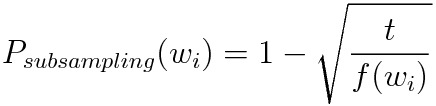

In [9]:
def subsampling(word_sequence):
    filtered_corpus = []
    word_counts = dict(Counter(word_sequence)) # Counter를 이용해 단어 빈도수 체크
    sum_word_counts = sum(list(word_counts.values())) # 단어 전체 등장 횟수
    word_freq = {word: word_counts[word]/float(sum_word_counts) for word in word_counts} # 단어 등장 횟수 / 전체 단어 등장 횟수
    for word in word_sequence:
        prob = 1-math.sqrt(1e-5 / word_freq[word])
        if  prob < random.random() and prob > 0: # 확률값이 0보다 크고, 랜덤확률보다 낮은 경우, None을 어팬드
            filtered_corpus.append(None)
        else : 
            filtered_corpus.append(word)
    return filtered_corpus

In [10]:
filtered_corpus = subsampling(word_sequence)

In [11]:
filtered_corpus[:50]

['1',
 '8',
 '3',
 '9',
 '년',
 None,
 '는',
 '괴테',
 '의',
 '파우스트',
 '을',
 '처음',
 '읽',
 '고',
 '그',
 '내용',
 '에',
 '마음',
 '이',
 '끌려',
 '이',
 '를',
 '소재',
 '로',
 '해서',
 None,
 '의',
 '교향곡',
 '을',
 '쓰',
 '려는',
 None,
 '을',
 '갖',
 None,
 '.',
 '이',
 '시기',
 None,
 '는',
 '1',
 '8',
 '3',
 '8',
 '년',
 '에',
 None,
 '독촉',
 '으로',
 '산전수전']

In [12]:
len(filtered_corpus) # 기존 4,093,756 개에서 3,470,137 개로 줆음.

4093756

## 3. Train 데이터 만들기

In [13]:
vocab = list(set(filtered_corpus)) # tuple로 중복을 제거하여 vocabulary를 만듦

In [14]:
len(vocab) # Vocabulary size

83316

In [15]:
word_to_idx = dict()
for word in vocab:
    word_to_idx[word] = len(word_to_idx)

In [16]:
word_to_idx

{'객석': 0,
 '아더': 1,
 '황현희': 6,
 '보주': 7,
 'YS': 8,
 '정토': 5,
 '지아': 58881,
 '하퍼리': 5261,
 '야야야': 81265,
 'arctos': 4,
 '휘장': 9,
 '운전석': 11,
 '"+",': 14,
 '瀑': 13,
 '감화가': 41708,
 '왕동': 44835,
 '비터': 15,
 '파노라마': 67057,
 '선배': 17,
 '신재하': 20,
 '장문': 19,
 '셔츠': 21,
 '벗어던졌': 22,
 'Mío': 41713,
 '청량리동': 28,
 '품신': 27,
 '성간': 26,
 '기울여야': 16797,
 'weapon': 46293,
 '固定': 29,
 '훔칠': 55730,
 '측천무후': 30,
 '학풍': 31,
 '고야마': 33,
 '사이': 34,
 '코피노': 38,
 '베드로': 37,
 '북원': 39,
 '부코': 13967,
 '티베트고원': 40,
 '결승전': 41,
 '할려는': 42883,
 '법황': 42,
 '시험장': 59154,
 '초극': 43,
 '약체': 44,
 '정윤': 15717,
 '이주해': 45,
 '장신': 49,
 '잠옷': 50,
 '골육': 51,
 '서인영': 53,
 '강성훈': 54,
 '祇': 55,
 '래는': 56,
 '고갯길': 59,
 '鐵線': 60,
 '賢主': 61,
 '지휘봉': 62,
 '정현전': 63,
 '아몰레드': 64,
 'Isangrim': 58015,
 '박지성': 65,
 '리토': 66,
 '에른스트': 67,
 'progenitor': 68,
 '추행': 69,
 'Swedish': 70,
 '가고시마': 71,
 'PARK': 72,
 '伺察': 78,
 '북해유전': 75,
 '돋보이': 69136,
 '연적': 77,
 '막춤': 79,
 '잡아갈': 80,
 '비세': 13971,
 '스타카토': 81,
 '아저씨': 83,
 '글라스': 13973,

In [17]:
idx_to_word = []
for word in word_to_idx.keys():
    idx_to_word.append(word)

In [18]:
idx_to_word

['객석',
 '아더',
 '황현희',
 '보주',
 'YS',
 '정토',
 '지아',
 '하퍼리',
 '야야야',
 'arctos',
 '휘장',
 '운전석',
 '"+",',
 '瀑',
 '감화가',
 '왕동',
 '비터',
 '파노라마',
 '선배',
 '신재하',
 '장문',
 '셔츠',
 '벗어던졌',
 'Mío',
 '청량리동',
 '품신',
 '성간',
 '기울여야',
 'weapon',
 '固定',
 '훔칠',
 '측천무후',
 '학풍',
 '고야마',
 '사이',
 '코피노',
 '베드로',
 '북원',
 '부코',
 '티베트고원',
 '결승전',
 '할려는',
 '법황',
 '시험장',
 '초극',
 '약체',
 '정윤',
 '이주해',
 '장신',
 '잠옷',
 '골육',
 '서인영',
 '강성훈',
 '祇',
 '래는',
 '고갯길',
 '鐵線',
 '賢主',
 '지휘봉',
 '정현전',
 '아몰레드',
 'Isangrim',
 '박지성',
 '리토',
 '에른스트',
 'progenitor',
 '추행',
 'Swedish',
 '가고시마',
 'PARK',
 '伺察',
 '북해유전',
 '돋보이',
 '연적',
 '막춤',
 '잡아갈',
 '비세',
 '스타카토',
 '아저씨',
 '글라스',
 '호북성',
 '曜',
 'Driessen',
 '銓郞',
 '뇌신',
 'Jonsin',
 '로이드',
 '프레데리크',
 '프란트',
 'Couture',
 '아사히나',
 '항법사',
 '남중',
 'IEG',
 '소토보',
 '⑹',
 '실기',
 'MV',
 '嬴',
 '닛폰',
 'Eng',
 '훈련',
 '이상자',
 '배서인',
 '실용주의',
 '총사',
 '대독일주의',
 '전기공',
 '전주',
 '그라',
 '천하',
 '당시',
 '급경사면',
 '寵',
 '계시',
 '포웰',
 '형언',
 '각초',
 '텍스처',
 'EGL',
 '목가극',
 '레이디호크',
 '수강료',
 '아그',
 '재시',
 '다녀올',
 

In [19]:
train_input = []
train_target = []

In [20]:
w = 2     # window size = 2
dim = 100 # embedding vector 차원

In [21]:
for i in range(w, len(filtered_corpus) -w):
    for k in range(2*w):
        train_input.append(word_to_idx[filtered_corpus[i]])
    context= []
    for j in range(-w, w+1):
        if j != 0:
            context.append(word_to_idx[filtered_corpus[i+j]])
    train_target.append(context)

In [22]:
train_input[0], train_target[0]

(9980, [82818, 11905, 14058, 58132])

In [23]:
len(train_input)

16375008

In [24]:
len(train_target)

4093752

In [25]:
train_target = np.array(train_target).reshape(-1,) # train_target을 1차원 배열로 만듦.

In [26]:
train_input[0], train_target[0]

(9980, 82818)

In [27]:
len(train_target)

16375008

In [28]:
train = torch.utils.data.TensorDataset(torch.tensor(train_input), torch.tensor(train_target))

## 4. 모델 정의

In [29]:
class Skipgram(nn.Module):
    def __init__(self, dim):
        super(Skipgram, self).__init__()
        self.embedding = nn.Embedding(len(vocab), dim)
        self.linear = nn.Linear(dim, len(vocab), bias=False)
    
    def forward(self, inputs):
        embeds = self.embedding(inputs)
        outs = self.linear(embeds)
#         log_probs = F.log_softmax(outs)
        return outs

In [30]:
batch_size = 500 # batch size 
input_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True) # dataloader 정의

In [31]:
model = Skipgram(dim).to(dev)

In [32]:
model.to(dev)

Skipgram(
  (embedding): Embedding(83316, 100)
  (linear): Linear(in_features=100, out_features=83316, bias=False)
)

In [33]:
loss_fn = nn.CrossEntropyLoss() # loss function = cross entropy 함수

In [34]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [35]:
epoch = 50
check = 5000

## 5. 모델 학습

In [36]:
x, y = next(iter(input_loader))

In [37]:
len(x)

500

In [38]:
x[0] == 14942

tensor(False)

In [39]:
if x[0] == 14941:
    print('ture')

In [40]:
word_to_idx[None]

10429

In [41]:
len(y)

500

In [42]:
x[0], y[0]

(tensor(53468), tensor(67970))

In [43]:
start = time.time()

loss_list = []

for epo in range(epoch):
    loss_sum = 0
    for i, (x, y) in enumerate(input_loader):
        
        x, y = x.to(dev), y.to(dev)
        optimizer.zero_grad()
        
        
        output = model(x)


        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()

        if i % check == 0 and i != 0:
            elap = int(time.time() - start)
            loss_list.append(loss_sum/check)
            print('Epoch: {}, Iteration : {}, Loss : {:.2f}, Elapsed time: {:.0f}h {:.0f}m {}s'.format(\
                    epo, i, loss_sum / check, elap // 3600, (elap % 3600) // 60, str(int((elap % 3600) % 60))))
            loss_sum = 0

Epoch: 0, Iteration : 5000, Loss : 6.39, Elapsed time: 0h 1m 8s
Epoch: 0, Iteration : 10000, Loss : 6.13, Elapsed time: 0h 2m 16s
Epoch: 0, Iteration : 15000, Loss : 6.06, Elapsed time: 0h 3m 23s
Epoch: 0, Iteration : 20000, Loss : 6.01, Elapsed time: 0h 4m 30s
Epoch: 0, Iteration : 25000, Loss : 5.99, Elapsed time: 0h 5m 37s
Epoch: 0, Iteration : 30000, Loss : 5.97, Elapsed time: 0h 6m 44s
Epoch: 1, Iteration : 5000, Loss : 5.87, Elapsed time: 0h 8m 29s
Epoch: 1, Iteration : 10000, Loss : 5.90, Elapsed time: 0h 9m 36s
Epoch: 1, Iteration : 15000, Loss : 5.90, Elapsed time: 0h 10m 43s
Epoch: 1, Iteration : 20000, Loss : 5.91, Elapsed time: 0h 11m 50s
Epoch: 1, Iteration : 25000, Loss : 5.91, Elapsed time: 0h 12m 57s
Epoch: 1, Iteration : 30000, Loss : 5.91, Elapsed time: 0h 14m 4s
Epoch: 2, Iteration : 5000, Loss : 5.83, Elapsed time: 0h 15m 49s
Epoch: 2, Iteration : 10000, Loss : 5.87, Elapsed time: 0h 16m 56s
Epoch: 2, Iteration : 15000, Loss : 5.89, Elapsed time: 0h 18m 3s
Epoch: 2,

Epoch: 20, Iteration : 20000, Loss : 5.89, Elapsed time: 2h 31m 4s
Epoch: 20, Iteration : 25000, Loss : 5.89, Elapsed time: 2h 32m 12s
Epoch: 20, Iteration : 30000, Loss : 5.90, Elapsed time: 2h 33m 19s
Epoch: 21, Iteration : 5000, Loss : 5.82, Elapsed time: 2h 35m 4s
Epoch: 21, Iteration : 10000, Loss : 5.87, Elapsed time: 2h 36m 11s
Epoch: 21, Iteration : 15000, Loss : 5.88, Elapsed time: 2h 37m 18s
Epoch: 21, Iteration : 20000, Loss : 5.89, Elapsed time: 2h 38m 25s
Epoch: 21, Iteration : 25000, Loss : 5.90, Elapsed time: 2h 39m 32s
Epoch: 21, Iteration : 30000, Loss : 5.90, Elapsed time: 2h 40m 39s
Epoch: 22, Iteration : 5000, Loss : 5.82, Elapsed time: 2h 42m 24s
Epoch: 22, Iteration : 10000, Loss : 5.86, Elapsed time: 2h 43m 31s
Epoch: 22, Iteration : 15000, Loss : 5.88, Elapsed time: 2h 44m 38s
Epoch: 22, Iteration : 20000, Loss : 5.89, Elapsed time: 2h 45m 45s
Epoch: 22, Iteration : 25000, Loss : 5.90, Elapsed time: 2h 46m 52s
Epoch: 22, Iteration : 30000, Loss : 5.90, Elapsed t

KeyboardInterrupt: 

In [44]:
def similar_words(model, word, k=10):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    
    word_id = torch.tensor([word_to_idx[word]])
    word_vec = model.embedding(word_id)
#     print(word_vec)
    word_mat = next(iter(model.embedding.parameters())).detach()
    print(word_mat.size)
    cos_mat = cos(word_vec, word_mat)
    sim, indices = torch.topk(cos_mat,k+1)
    
    
    word_list = []
    for i in indices:
        if i != word_id:
            word_list.append(idx_to_word[i])
    return word_list, sim[1:].detach()

In [45]:
similar_words(model.to('cpu'), '대통령')

<built-in method size of Tensor object at 0x7f641a2323f0>


(['스로', '武漢', '택지', '허세', '둘러싸이', '수필집', '병사', '에비아', '유복', 'Tre'],
 tensor([0.5851, 0.5345, 0.5310, 0.5268, 0.5147, 0.5122, 0.4984, 0.4984, 0.4952,
         0.4816]))

In [46]:
torch.save(model.state_dict(), "./data/word-embeddings/word2vec/191106_word2vec_skipgram_korquad_epoch50")